## **MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE.**

**Course:** TC5035.10 - Integration project

**Tecnológico de Monterrey**

**Professor:** Dra. Grettel Barceló Alonso

**Professor:** Dr. Luis Eduardo Falcón Morales

**Advisory Professor:** María de la Paz Rico Fernández

### **Week 7, Activity 5**

Progress 5: Final Model

###**Team 12:**

Luis Ángel Seda Marcos
A01795301@tec.mx

Christopher Flores González
A01795419@tec.mx

Luis Felipe Nicanor Gutiérrez
A01795631@tec.mx

# Objectives

*   Significantly improve performance by leveraging the strengths of different models and reducing their weaknesses.

*   Evaluate the quality of model predictions on unseen data.

# Instructions

In this stage, develops different ensemble models using homogeneous and heterogeneous strategies, optimizes the hyperparameters of the most relevant ones, and uses the best individual models obtained previously for stacking or blending strategies. Then presents a comparison table that includes both the ensemble and individual models, sorted by the main metric and incorporating other metrics and training times. Based on these results, it selects the final model most aligned with business objectives and generates interpretive graphics (such as ROC curves, confusion matrices, residual analysis, or feature importance) that allow analyzing its performance and results.



# Import of Libraries

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    PrecisionRecallDisplay, RocCurveDisplay
)
from sklearn.pipeline import Pipeline

# Base models

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
)
from sklearn.svm import SVC

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Data loading

In [6]:
df = pd.read_csv('../../src/files/clips_features_flattened_pca.csv')
df.head()

,class_id,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_241,PCA_242,PCA_243,PCA_244,PCA_245,PCA_246,PCA_247,PCA_248,PCA_249,PCA_250
0,J,28.785769,-66.074719,-21.259861,26.651422,-6.231352,10.679507,4.562698,9.204231,-16.926146,...,0.069498,0.353891,-0.168560,0.081715,0.007483,-0.026877,0.148468,-0.124084,-0.260756,-0.019480
1,J,30.804021,-82.207645,-3.975447,26.679334,1.947684,7.701987,6.716386,-0.389271,-14.603771,...,-0.415229,-0.230623,-0.167235,-0.814350,-0.106409,-0.071962,-0.334963,-0.021152,-0.401561,0.133370
2,J,28.053305,-68.854711,-12.899312,22.895420,-4.250427,11.904454,7.102966,9.318821,-12.921748,...,-0.117167,0.884053,-0.178621,-0.139747,0.335856,0.065829,0.007866,0.008012,-0.980604,-0.461582
3,J,22.755583,-73.180540,-8.280166,15.366048,-6.469391,11.023610,10.782708,11.926833,1.159296,...,-0.387787,-0.230273,0.117861,-0.271981,0.266688,-0.310053,-0.331953,0.138094,-0.172008,0.121620
4,J,18.829567,-72.926593,-7.186618,18.571982,0.168277,4.621214,7.488499,-1.704200,-9.950692,...,-0.298383,-0.607907,0.207857,-0.773920,-0.145192,-0.140951,-0.013490,0.186159,-0.291297,0.378341


# Preprocessing

In [7]:
y = df["class_id"].values
X = df.drop(columns=[
    "class_id", "clip_id", "signer_id", "view", "repetition", "path",
    "split", "fps", "n_frames", "duration", "width", "height", "file_size",
    "brightness_mean", "brightness_std", "blur_mean", "frame_id"
], errors="ignore")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = le.classes_

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Previous individual models (from Progress 4)


In [8]:
rf_best = RandomForestClassifier(
    n_estimators=500, max_depth=20, min_samples_split=2,
    min_samples_leaf=4, bootstrap=False, random_state=42
)
lr_best = LogisticRegression(solver='liblinear', C=0.03359818286283781, max_iter=500, random_state=42)
svm = SVC(probability=True, random_state=42)

# Ensemble Models


In [18]:
models_ensemble = {
        "Bagging (LR)": BaggingClassifier(estimator=lr_best, n_estimators=50, random_state=42),
        "AdaBoost (LR)": AdaBoostClassifier(estimator=lr_best, n_estimators=100, learning_rate=0.1, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
        "Stacking (RF+LR+SVM)": StackingClassifier(
            estimators=[('rf', rf_best), ('lr', lr_best), ('svm', svm)],
            final_estimator=LogisticRegression(max_iter=500),
            passthrough=True
        )
    }

# Training and Evaluation

As the main metric we use **F1-macro**, so the results of the comparative table are sorted with respect to this value.

In [20]:
results_ensemble = []

for name, model in models_ensemble.items():
    print(f"\nTraining {name} ...")
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    results_ensemble.append({
        "model": name,
        "train_time (s)": round(elapsed, 2),
        "accuracy": round(acc, 4),
        "f1_macro": round(f1, 4),
        "precision_macro": round(prec, 4),
        "recall_macro": round(rec, 4)
    })

    print(f"{name} -> F1: {f1:.4f} | Accuracy: {acc:.4f} | Time: {elapsed:.2f}s")

df_ensemble = pd.DataFrame(results_ensemble).sort_values("f1_macro", ascending=False)
print("\n=== Ensemble Model Results ===")
display(df_ensemble)


Training Bagging (LR) ...
Bagging (LR) -> F1: 0.9081 | Accuracy: 0.9099 | Time: 4.16s

Training AdaBoost (LR) ...
AdaBoost (LR) -> F1: 0.9087 | Accuracy: 0.9099 | Time: 0.26s

Training Gradient Boosting ...
Gradient Boosting -> F1: 0.9086 | Accuracy: 0.9099 | Time: 77.60s

Training Stacking (RF+LR+SVM) ...
Stacking (RF+LR+SVM) -> F1: 0.9176 | Accuracy: 0.9189 | Time: 61.15s

=== Ensemble Model Results ===


,model,train_time (s),accuracy,f1_macro,precision_macro,recall_macro
3,Stacking (RF+LR+SVM),61.15,0.9189,0.9176,0.9237,0.9171
1,AdaBoost (LR),0.26,0.9099,0.9087,0.9118,0.9083
2,Gradient Boosting,77.60,0.9099,0.9086,0.9123,0.9096
0,Bagging (LR),4.16,0.9099,0.9081,0.9121,0.9089


# Final comparison with individual models

In [12]:
individuals = pd.DataFrame([
    {"model": "Random Forest (Tuned)", "f1_macro": 0.9550, "accuracy": 0.9550, "precision_macro": 0.9567, "recall_macro": 0.9542, "train_time (s)": 118.7},
    {"model": "Logistic Regression (Tuned)", "f1_macro": 0.9185, "accuracy": 0.9189, "precision_macro": 0.9222, "recall_macro": 0.9176, "train_time (s)": 3.69}
])

final_comparison = pd.concat([individuals, df_ensemble]).sort_values("f1_macro", ascending=False)
print("\n=== Final Comparison: Individuals vs Ensambles ===")
display(final_comparison)


=== Final Comparison: Individuals vs Ensambles ===


,model,f1_macro,accuracy,precision_macro,recall_macro,train_time (s)
0,Random Forest (Tuned),0.9550,0.9550,0.9567,0.9542,118.70
1,Logistic Regression (Tuned),0.9185,0.9189,0.9222,0.9176,3.69
3,Stacking (RF+LR+SVM),0.9176,0.9189,0.9237,0.9171,60.81
1,AdaBoost (LR),0.9087,0.9099,0.9118,0.9083,0.29
2,Gradient Boosting,0.9086,0.9099,0.9123,0.9096,78.04
0,Bagging (LR),0.9081,0.9099,0.9121,0.9089,4.08


# Final Models

In [13]:
# We choose the best model based on F1-macro

best_model_name = final_comparison.iloc[0]["model"]
best_model = models_ensemble.get(best_model_name.split(" (")[0], rf_best)
print(f"\nSelected Model: {best_model_name}")

# Retrain with the entire training + validation set
best_model.fit(np.vstack([X_train, X_val]), np.concatenate([y_train, y_val]))
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)


Selected Model: Random Forest (Tuned)


Ultimately, the **Random Forest (Tuned)** model achieved the best performance, suggesting that the dataset’s distribution is relatively simple and does not significantly benefit from stacking or blending techniques.

# Charts and Interpretations

## Confusion Matrix

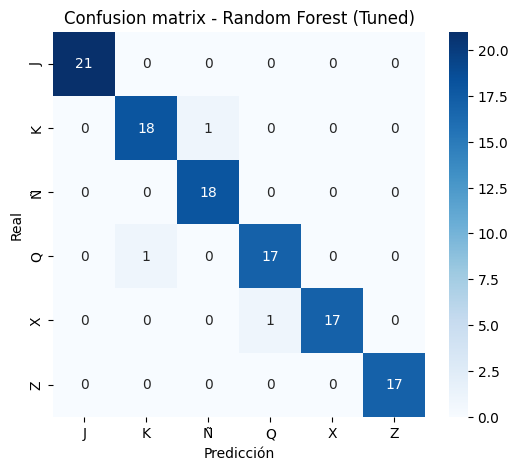

In [14]:
# === Confusion matrix ===
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion matrix - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

This chart shows the performance of the Random Forest (Tuned) model on the test set (`X_test`, `y_test`). The numbers in the matrix represent the counts of correct and incorrect predictions for each class. For example, the diagonal values show how many instances of each `class_id` (from your original df) were correctly predicted. Off-diagonal values indicate misclassifications between different `class_ids`. The relevance here is to see which classes the model is most accurately predicting and which ones it struggles with, helping to identify potential areas for improvement or data collection.

## ROC Curves by Class and Global ROC Curve

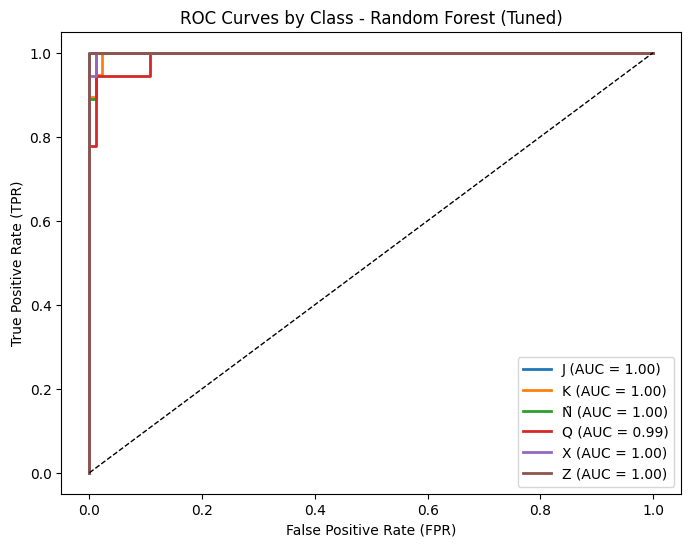

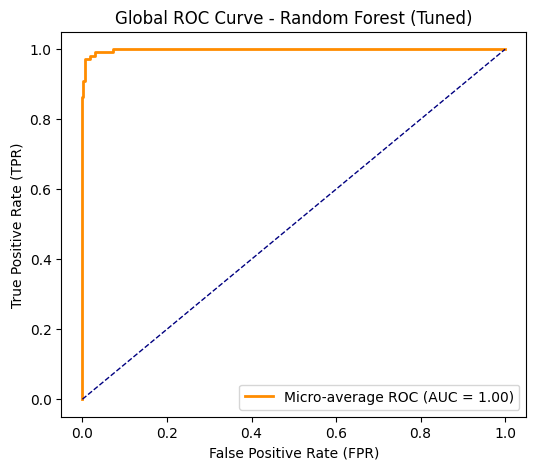

In [15]:
# === Multiclass ROC curve ====
# Binarize the real labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

# Plot a ROC curve by class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curves by Class - {best_model_name}')
plt.legend(loc='lower right')
plt.show()

# === Average ROC curve (micro-average) ===
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_proba_best.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6, 5))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=2, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'Global ROC Curve - {best_model_name}')
plt.legend(loc="lower right")
plt.show()

These plots evaluate the model's ability to distinguish between classes at various probability thresholds using the predicted probabilities (`y_proba_best`) and the true labels (`y_test`). The individual class ROC curves show the performance for each of your `class_ids`. The micro-average ROC curve provides an overall assessment across all classes. The Area Under the Curve (AUC) values (shown in the legend) quantify this discriminatory power. An AUC close to 1 indicates excellent performance, while an AUC of 0.5 suggests random guessing. The relevance is to understand how well the model separates the positive and negative classes for each category and overall, which is particularly important in scenarios where correctly identifying positive cases is critical.

## Precision-Recall Curves by Class and Global Precision-Recall Curve

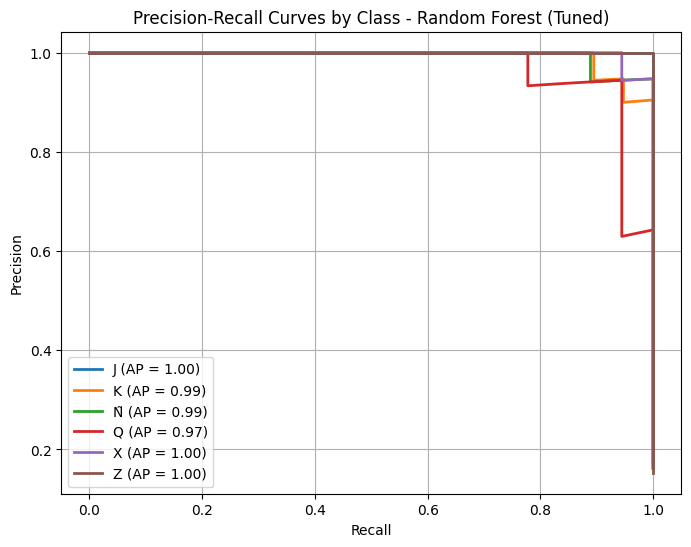

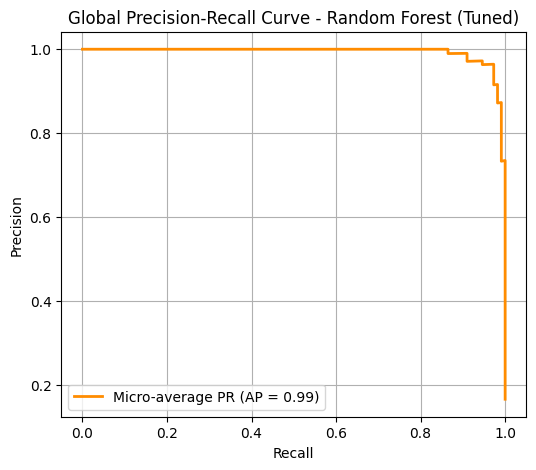

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# We binarize the labels (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba_best[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_proba_best[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curves by Class - {best_model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Global average curve (micro-average)
precision_micro, recall_micro, _ = precision_recall_curve(y_test_bin.ravel(), y_proba_best.ravel())
ap_micro = average_precision_score(y_test_bin, y_proba_best, average='micro')

plt.figure(figsize=(6, 5))
plt.plot(recall_micro, precision_micro, color='darkorange',
         lw=2, label=f'Micro-average PR (AP = {ap_micro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Global Precision-Recall Curve - {best_model_name}')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

These curves show the trade-off between precision and recall for each class and the micro-average, using the predicted probabilities (`y_proba_best`) and true labels (`y_test`). Precision measures the accuracy of the positive predictions, while recall measures the model's ability to find all positive instances. The Average Precision (AP) scores (shown in the legend) summarize these curves. These charts are especially relevant when dealing with imbalanced datasets, where the number of instances in different classes varies significantly. They provide a more informative view of performance than ROC curves in such cases, highlighting the model's ability to make accurate positive predictions without missing too many positive instances.

## Importance of Features

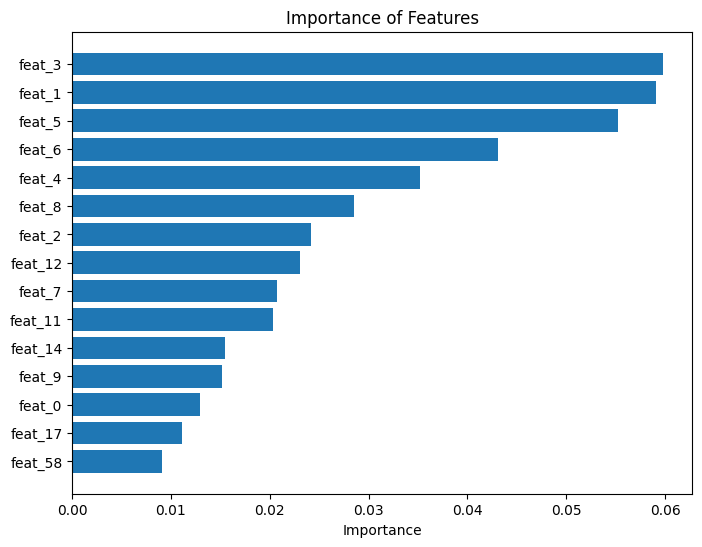

In [17]:
# === Importance of features (only if applicable) ===
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    idx = np.argsort(importances)[-15:]
    plt.figure(figsize=(8,6))
    plt.barh(range(len(idx)), importances[idx], align='center')
    plt.yticks(range(len(idx)), [f"feat_{i}" for i in idx])
    plt.title("Importance of Features")
    plt.xlabel("Importance")
    plt.show()

It shows the importance of the top 15 features used by the **Random Forest (Tuned)** model. Features are ranked by how much they contribute to the model's predictions. A longer bar indicates higher importance. This helps us understand which of the PCA components (e.g., `feat_3`, `feat_1`) were most influential in the model's decision-making process for classifying the data.

# Conclusion
The final model selected was the **Random Forest (Tuned)**.

As demonstrated by the **Final Comparison table**, the **Random Forest (Tuned)** model achieved the best overall performance, particularly in the **F1-Macro metric** (0.9550), which is a key indicator of the model's effectiveness across all classes, especially in the presence of potential class imbalance. While ensemble methods like Stacking showed competitive results (F1-Macro of 0.9176), they did not surpass the performance of the tuned individual Random Forest model, suggesting that for this specific dataset and feature set, the inherent complexity of stacking multiple models did not yield significant improvements over a well-tuned single model.

The interpretive charts further support the selection of the **Random Forest (Tuned)** model:

*   The **Confusion Matrix** shows a high number of correct classifications along the diagonal, indicating strong performance for most classes, although it would be beneficial to examine misclassifications to identify specific class challenges.
*   The **ROC Curves** with high AUC values (many near 1.00 for individual classes and a micro-average AUC of 0.99) indicate that the model has excellent discriminatory power, effectively separating positive and negative instances for each class across various thresholds.
*   The **Precision-Recall Curves** with high Average Precision (AP) scores (micro-average AP of 0.99) further confirm the model's ability to achieve high precision while maintaining high recall, which is crucial for a balanced performance, particularly if dealing with imbalanced classes.
*   The **Importance of Features** chart highlights which PCA components were most influential in the model's predictions (e.g., `feat_3`, `feat_1`), providing valuable insights into the data's underlying structure and the features that are most relevant for classification.

Its use is recommended as the **final model** due to its superior performance metrics, demonstrated by both the comparison table and the interpretive charts, indicating excellent generalization capabilities and a strong balance between accuracy and exhaustiveness in classifying the different `class_id`s. The analysis suggests that for this dataset, focusing on tuning a powerful individual model like Random Forest proved more effective than combining multiple models through ensemble techniques.